In [149]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn import ensemble
from sklearn.model_selection import train_test_split , RandomizedSearchCV , StratifiedShuffleSplit
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [150]:
data = pd.read_csv('Data/data.csv')

In [151]:
source = data.drop(['id','Unnamed: 32','diagnosis'],axis=1)
target = data.diagnosis
# standardization
source_s = (source - source.mean()) / (source.std()) 

# Feature Selection with Random Forest

In [152]:
model = ensemble.RandomForestClassifier(n_estimators=250,class_weight='balanced', max_depth=25)
model.fit(source_s, target)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [153]:
df_plot = pd.DataFrame({'features': source_s.columns,
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

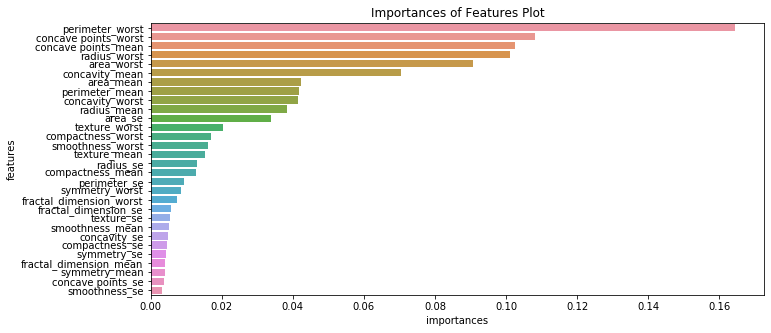

In [154]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

**I selected the most informative columns using Random Forest Model.**

In [156]:
informative_columns_RF = source_s.drop(df_plot.features[df_plot.importances < 0.06].tolist(), 1).columns
informative_columns_RF

Index(['concavity_mean', 'concave points_mean', 'radius_worst',
       'perimeter_worst', 'area_worst', 'concave points_worst'],
      dtype='object')

**Now we select informative columns from whole data.**

In [157]:
df_informative_RF = source_s[informative_columns_RF]
df_informative_RF.head()

,concavity_mean,concave points_mean,radius_worst,perimeter_worst,area_worst,concave points_worst
0,2.650542,2.530249,1.885031,2.301575,1.999478,2.294058
1,-0.023825,0.547662,1.804340,1.533776,1.888827,1.086129
2,1.362280,2.035440,1.510541,1.346291,1.455004,1.953282
3,1.914213,1.450431,-0.281217,-0.249720,-0.549538,2.173873
4,1.369806,1.427237,1.297434,1.337363,1.219651,0.728618


# Feature Selection with Boruta

In [158]:
from boruta import BorutaPy
boruta_feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=4242, max_iter = 50, perc = 90)
boruta_feature_selector.fit(source_s.values, target.values)

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	18
Tentative: 	12
Rejected: 	0
Iteration: 	9 / 50
Confirmed: 	18
Tentative: 	12
Rejected: 	0
Iteration: 	10 / 50
Confirmed: 	18
Tentative: 	12
Rejected: 	0
Iteration: 	11 / 50
Confirmed: 	18
Tentative: 	12
Rejected: 	0
Iteration: 	12 / 50
Confirmed: 	19
Tentative: 	11
Rejected: 	0
Iteration: 	13 / 50
Confirmed: 	19
Tentative: 	11
Rejected: 	0
Iteration: 	14 / 50
Confirmed: 	19
Tentative: 	11
Rejected: 	0
Iteration: 	15 / 50
Confirmed: 	19
Tentative: 	11
Rejected: 	0
Iteration: 	16 / 50
Confirmed: 	21
Tentative: 	9
Rejected: 	0
Iteration

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=25,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=30, n_jobs=None,
                                          oob_score=False,
                                          random_state=<mtrand.RandomState object at 0x000002437224E558>,
                                          verbose=0, warm_start=False),
         max

**After Boruta has run we can transform our dataset.**

In [160]:
X_filtered = boruta_feature_selector.transform(source_s.values)
X_filtered.shape

(569, 23)

In [161]:
features = [f for f in source.columns if f not in ['diagnosis']]

final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print(final_features)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'fractal_dimension_mean', 'radius_se', 'perimeter_se', 'area_se', 'concavity_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


**Now we select informative columns from whole data.**

In [162]:
df_informative_Boruta = source_s[final_features]
df_informative_Boruta.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,fractal_dimension_mean,radius_se,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.253764,2.487545,...,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,-0.867889,0.498816,...,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,-0.397658,1.227596,...,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,4.906602,0.326087,...,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.561956,1.269426,...,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751


# Feature Selection with Variance Inflation Factor (VIF)

In [163]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [164]:
from sklearn.preprocessing import Imputer

transformer = ReduceVIF()

# Only use 10 columns for speed in this example
df_informative_VIF = transformer.fit_transform(source_s, target)

df_informative_VIF.head()

C:\Users\Amin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


ReduceVIF fit
ReduceVIF transform
Dropping radius_mean with vif=3806.1152963979675
Dropping radius_worst with vif=616.3508614719424
Dropping perimeter_mean with vif=325.64131198187516
Dropping perimeter_worst with vif=123.25781086343038
Dropping concavity_mean with vif=64.65479584770004
Dropping radius_se with vif=35.61751844352034
Dropping compactness_worst with vif=33.96063880508537
Dropping concave points_worst with vif=30.596655364833975
Dropping area_mean with vif=25.387829695531387
Dropping compactness_mean with vif=18.843208489973282
Dropping texture_worst with vif=17.232376192128665
Dropping area_se with vif=16.333806476471736
Dropping concavity_worst with vif=15.510661467365699
Dropping concave points_mean with vif=8.984359709155799
Dropping fractal_dimension_worst with vif=8.390012851546278
Dropping smoothness_worst with vif=7.507052167419571
Dropping compactness_se with vif=5.134581811858041


,texture_mean,smoothness_mean,symmetry_mean,fractal_dimension_mean,texture_se,perimeter_se,smoothness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,area_worst,symmetry_worst
0,-2.071512,1.567087,2.215566,2.253764,-0.564768,2.830540,-0.213814,0.723390,0.660239,1.147747,0.906286,1.999478,2.748204
1,-0.353322,-0.826235,0.001391,-0.867889,-0.875473,0.263095,-0.604819,-0.440393,0.259933,-0.804742,-0.099356,1.888827,-0.243675
2,0.455786,0.941382,0.938859,-0.397658,-0.779398,0.850180,-0.296744,0.212889,1.423575,0.236827,0.293301,1.455004,1.151242
3,0.253509,3.280667,2.864862,4.906602,-0.110312,0.286341,0.689095,0.818798,1.114027,4.728520,2.045711,-0.549538,6.040726
4,-1.150804,0.280125,-0.009552,-0.561956,-0.789549,1.272070,1.481763,0.827742,1.143199,-0.360775,0.498889,1.219651,-0.867590


# Split data on balanced training set and test set

In [166]:
# Train & Test split Randon Forest
train_data_RF, test_data_RF, train_labels_RF, test_labels_RF = train_test_split(df_informative_RF, target, test_size = 0.3, random_state=0, stratify=target)
# Train & Test split Boruta
train_data_Boruta, test_data_Boruta, train_labels_Boruta, test_labels_Boruta = train_test_split(df_informative_Boruta, target, test_size = 0.3, random_state=0, stratify=target)
# Train & Test split VIF
train_data_VIF, test_data_VIF, train_labels_VIF, test_labels_VIF = train_test_split(df_informative_VIF, target, test_size = 0.3, random_state=0, stratify=target)

**To split data on balanced training set and test set on sklearn, we use stratify parameter on target:**

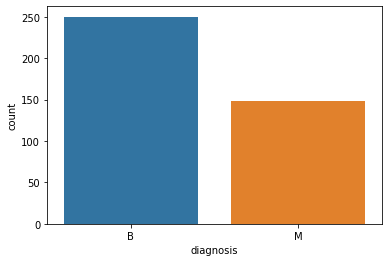

In [167]:
ax = sns.countplot(train_labels_RF,label="Count")       
B, M = target.value_counts()

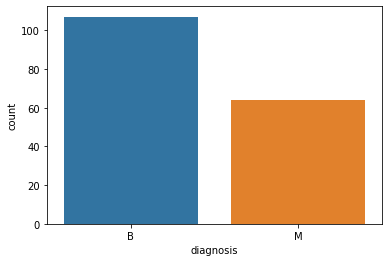

In [168]:
ax = sns.countplot(test_labels_RF,label="Count")       
B, M = target.value_counts()

**Now we see each train labels and test labels has same portion of each group.**

# XGboost

**Parameters Tuning**

In [169]:
# Create model

model = xgb.XGBClassifier()

# Create parameters grid

parameters_grid = { 'learning_rate' : [0.1, 0.2, 0.5], 'max_depth' : [5, 10, 15], 'n_estimators' : [150, 250, 300], 'min_child_weight' : [3, 5, 10] }

# Strategy of cross validation

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3)

# Create Grid search Strategy

grid_cv = RandomizedSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

# Fit model by Grid

grid_cv.fit(train_data, train_labels)

# Model with the best estimator

grid_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [186]:
model_RF = xgb.XGBClassifier(learning_rate=0.2, max_depth=10, min_child_weight=10, n_estimators=250)
model_Boruta = xgb.XGBClassifier(learning_rate=0.2, max_depth=10, min_child_weight=10, n_estimators=250)
model_VIF = xgb.XGBClassifier(learning_rate=0.2, max_depth=10, min_child_weight=10, n_estimators=250)

In [187]:
# with Randon Forest features
model_RF.fit(train_data_RF, train_labels_RF)
# Predicting
predict_labels_RF = model_RF.predict(test_data_RF)

# with Boruta features
model_Boruta.fit(train_data_Boruta, train_labels_Boruta)
# Predicting
predict_labels_Boruta = model_Boruta.predict(test_data_Boruta)


# with VIF features
model_VIF.fit(train_data_VIF, train_labels_VIF)
# Predicting
predict_labels_VIF = model_VIF.predict(test_data_VIF)

# The results of the XGBoost algorithm with Random Forest feature selection

In [188]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_RF, predict_labels_RF))

              precision    recall  f1-score   support

           B       0.96      0.91      0.93       107
           M       0.86      0.94      0.90        64

    accuracy                           0.92       171
   macro avg       0.91      0.92      0.91       171
weighted avg       0.92      0.92      0.92       171



In [189]:
ac = accuracy_score(test_labels_RF,model_RF.predict(test_data_RF))
print('Accuracy is: ',ac)

Accuracy is:  0.9181286549707602


# The results of the XGBoost algorithm with Boruta feature selection

In [190]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_Boruta, predict_labels_Boruta))

              precision    recall  f1-score   support

           B       0.96      0.93      0.94       107
           M       0.88      0.94      0.91        64

    accuracy                           0.93       171
   macro avg       0.92      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171



In [191]:
ac = accuracy_score(test_labels_Boruta,model_Boruta.predict(test_data_Boruta))
print('Accuracy is: ',ac)

Accuracy is:  0.9298245614035088


# The results of the XGBoost algorithm with VIF feature selection

In [192]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_VIF, predict_labels_VIF))

              precision    recall  f1-score   support

           B       0.97      0.93      0.95       107
           M       0.88      0.95      0.92        64

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171



In [193]:
ac = accuracy_score(test_labels_VIF,model_VIF.predict(test_data_VIF))
print('Accuracy is: ',ac)

Accuracy is:  0.935672514619883
